# **TRADITIONAL HNN**

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from time import time

# For ADAM training
SEED_TORCH = 91234
DEVICE = 'cuda' # choose accordingly to our hardware 'cpu' or 'cuda'
NUM_TRAIN_STEPS = 20000
BATCH_SIZE = 512
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-13
NUM_HIDDEN_NEURONS = 1000
torch.manual_seed(SEED_TORCH)
torch.set_default_dtype(torch.float64)
torch.set_num_threads(os.cpu_count())

# For generating data
SEED_DATA = 752123
RNG = np.random.default_rng(SEED_DATA)
NUM_POINTS = 10000
TRAIN_SPLIT = 0.8 # means we use 80% of the data for training
                  #              20% of the data for testing

GOLDEN_RATIO = (1 + 5**0.5) / 2 # for plotting

def spring_hamiltonian(x):
    # H(q,p) = 1/(2m) * p^2 + k/2 (q-L)^2 
    # with Mass m=1, Spring constant k=1, natural spring length L=1  
    # H(q,p) = 0.5 * p^2 + 0.5 * (q-1)^2
    q, p = np.split(x, 2, axis=-1)
    return 0.5 * p**2 + 0.5 * (q-1)**2

def dxdt(x):
    # returns dx/dt = (dq/dt, dp/dt) (time derivative of input)
    q, p = np.split(x, 2, axis=-1)
    dHdq, dHdp = q-1, p
    # Hamilton's equations
    dqdt, dpdt = dHdp, -dHdq
    return np.column_stack([dqdt.flatten(), dpdt.flatten()])
    
qs = RNG.uniform(low=-5, high=5, size=(NUM_POINTS))
ps = RNG.uniform(low=-5, high=5, size=(NUM_POINTS))
x = np.column_stack([qs.flatten(), ps.flatten()])

# Shuffle
idx = RNG.permutation(x.shape[0])
x = x[idx]

# Train/Test split
split_idx = int(x.shape[0] * TRAIN_SPLIT) 
x_train, x_test = x[:split_idx], x[split_idx:]
x_dot_train = dxdt(x_train)

# We assume we know the Hamiltonian at one point
# to correctly set the integration constant.
# Here we assumed we know where 'energy' is zero:
# -> At the equilibrium.
x0_train = np.array([[1.,0.]])
H0_train = spring_hamiltonian(x0_train) # equals zero

# Ground truths
y_train = spring_hamiltonian(x_train)
y_test = spring_hamiltonian(x_test)

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def init_params(self):
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, x):
        x = self.flatten(x)

        # dense layer
        x = self.linear1(x)
        x = self.activation(x)

        # linear layer
        x = self.linear2(x)

        return x

class HNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HNN, self).__init__()

        self.mlp = MLP(input_dim, hidden_dim, 1)

    def init_params(self):
        self.mlp.init_params()

    def forward(self, x):
        hamil = self.mlp(x)
        
        # Auto-diff
        hamil_dx = torch.autograd.grad(hamil.sum(), x, create_graph=True)[0]
        hamil_dq, hamil_dp = torch.split(hamil_dx, hamil_dx.shape[1] // 2, dim=1)

        # Hamilton's equations
        q_dot = hamil_dp
        p_dot = -hamil_dq

        return torch.cat((q_dot, p_dot), dim=1)

In [3]:
def get_batch(x, step, batch_size, requires_grad=False):
    x_len, _ = x.shape
    i_begin = (step * batch_size) % x_len
    x_batch = x[i_begin:i_begin + batch_size, :]
    return torch.tensor(x_batch, requires_grad=requires_grad, device=DEVICE)

def train_step(model, optim, x, x_dot_true, idx_step):
    x_dot_pred = model.forward(x)
    loss = (x_dot_true - x_dot_pred).pow(2).mean() 
    loss.backward(); optim.step(); optim.zero_grad()
    
    if idx_step % 1000 == 0:
        print(f"-> Loss at step {idx_step}\t:\t{loss}")
    
    return loss.item()

def adam_train(model, x_train, x_dot_train, x0, H0):
    model.to(DEVICE); model.train(); model.init_params()
    optim = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    train_losses = []
    
    print("Step No. : Loss (Squared L2 Error)")
    for idx_step in range(NUM_TRAIN_STEPS):
        x = get_batch(x_train, idx_step, BATCH_SIZE, requires_grad=True)
        x_dot_true = get_batch(x_dot_train, idx_step, BATCH_SIZE)
        loss = train_step(model, optim, x, x_dot_true, idx_step)
        train_losses.append(loss)

    # fit integration constant
    x = get_batch(x0, 0, 1)
    Hx_true = get_batch(H0, 0, 1)
    
    # MLP inside HNN outputs H(x)
    Hx_pred = model.mlp(x) 
    bias = Hx_true - (Hx_pred - model.mlp.linear2.bias)
    model.mlp.linear2.bias = torch.nn.Parameter(bias)

    model.cpu()
    return train_losses

hnn = HNN(2, NUM_HIDDEN_NEURONS)

t0 = time()
train_losses = adam_train(hnn, x_train, x_dot_train, x0_train, H0_train)
t1 = time()
print(f"ADAM Training took {(t1-t0):.2f} seconds")

Step No. : Loss (Squared L2 Error)
-> Loss at step 0	:	9.166620170224373
-> Loss at step 1000	:	0.14055598274427927
-> Loss at step 2000	:	0.03968222253960815
-> Loss at step 3000	:	0.006188703562679319
-> Loss at step 4000	:	0.001019798166330366
-> Loss at step 5000	:	0.0004143027300596902
-> Loss at step 6000	:	0.00022238914033516528
-> Loss at step 7000	:	0.00014067631221719964
-> Loss at step 8000	:	9.923729565334882e-05
-> Loss at step 9000	:	7.018652441054191e-05
-> Loss at step 10000	:	4.204448302921361e-05
-> Loss at step 11000	:	2.7598203430236648e-05
-> Loss at step 12000	:	2.093595335230911e-05
-> Loss at step 13000	:	1.8605417090697093e-05
-> Loss at step 14000	:	1.7991948831736492e-05
-> Loss at step 15000	:	1.149122451112528e-05
-> Loss at step 16000	:	1.6616925780318086e-05
-> Loss at step 17000	:	1.3141743594426373e-05
-> Loss at step 18000	:	1.1771128916973535e-05
-> Loss at step 19000	:	1.0088295290688012e-05
ADAM Training took 49.29 seconds


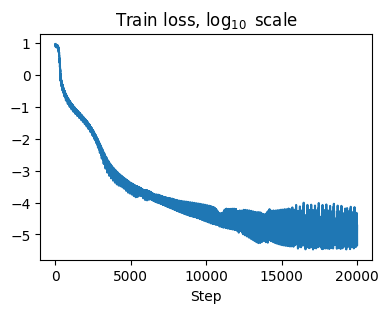

In [4]:
fig, ((ax)) = plt.subplots(1, 1, figsize=(4, 2*GOLDEN_RATIO), dpi=100)
ax.plot(list(range(1, NUM_TRAIN_STEPS+1)), np.log10(train_losses))
ax.set_xlabel('Step')
ax.set_title(r'Train loss, $\log_{10}$ scale')
fig.tight_layout()
fig.savefig("../../static/images/posts/training-hnns-without-backprop/hnn-training-loss.png")

In [5]:
def rel_l2_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred)**2).sum()) / np.sqrt(((y_true)**2).sum())

hnn.eval()

y_train_pred = hnn.mlp(torch.tensor(x_train)).detach().numpy()
y_test_pred = hnn.mlp(torch.tensor(x_test)).detach().numpy()

hnn_train_error = rel_l2_error(y_train, y_train_pred)
hnn_test_error = rel_l2_error(y_test, y_test_pred)

print(f"HNN train error: {hnn_train_error:.2E}")
print(f"HNN test  error: {hnn_test_error:.2E}")

HNN train error: 1.55E-03
HNN test  error: 1.55E-03


# **SAMPLING HNNs**

In [6]:
from sklearn.pipeline import Pipeline
from swimnetworks.swimnetworks import Dense, Linear

SEED_MODEL = 91234 # to be used in the swimnetworks

# sampling parameters
RCOND = 1e-13

In [7]:
class SampledMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SampledMLP, self).__init__()
        
        steps = [
            (
                "dense",
                Dense(
                    layer_width=NUM_HIDDEN_NEURONS, 
                    activation="tanh", 
                    elm_bias_start=-5., 
                    elm_bias_end=5., 
                    parameter_sampler="random",
                    sample_uniformly=True,
                    resample_duplicates=True,
                    random_seed=SEED_MODEL,
                )
            ),
            (
                "linear",
                Linear(layer_width=output_dim, regularization_scale=RCOND)
            )
        ]
        self.pipeline = Pipeline(steps)

    def forward(self, x):
        return self.pipeline.transform(x)

def tanh_grad(x):
    # analytical gradient of tanh
    return 1 - np.tanh(x)**2

class SampledHNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SampledHNN, self).__init__()
        
        self.mlp = SampledMLP(input_dim, hidden_dim, 1)

    def dense_grad(self, x):
        # Computes the gradient of dense_layer w.r.t. x
        dense_layer = self.mlp.pipeline[0]
        linear_layer = self.mlp.pipeline[-1]
        
        dense_layer.activation = tanh_grad
        dense_grad = dense_layer.transform(x)
        dense_layer.activation = np.tanh
        
        # computes dense_grad
        dense_grad = np.einsum('ij,kj->ikj', dense_grad, dense_layer.weights)

        return dense_grad
    
    def forward(self, x):
        # Compute the Hamiltonian gradient dHdx analytically
        # dense_grad * linear_weights
        dense_grad = self.dense_grad(x)
        linear_layer = self.mlp.pipeline[-1]

        # computes dHdx = dense_grad * linear_weights
        dHdx = (dense_grad @ linear_layer.weights).reshape(x.shape)

        dHdq, dHdp = np.split(dHdx, 2, axis=1)

        # Hamilton's Equations
        q_dot = dHdp
        p_dot = -dHdq

        return np.hstack((q_dot, p_dot))

In [8]:
def sampling_train(model, x_train, x_dot_train, x0, H0, method):
    dense_layer = model.mlp.pipeline[0]
    linear_layer = model.mlp.pipeline[-1]

    if method == "ELM":
        dense_layer.parameter_sampler = "random"
    else:
        dense_layer.parameter_sampler = "tanh"
    
    dense_layer.__post_init__()

    # sample hidden layer parameters (unsupervised)
    dense_layer.fit(x_train)

    dense_grad = model.dense_grad(x_train)
    dense_x0 = dense_layer.transform(x0)
    params = solve_linear_system(dense_grad, dense_x0, x_dot_train, H0)

    # set linear layer weights and biases to the least-squres solution
    linear_layer.weights = params[:-1].reshape((-1, 1))
    linear_layer.biases = params[-1].reshape((1, 1))

    # re-sample supervised if Approximate SWIM 
    if method == "A-SWIM":
        y_pred = model.mlp(x_train)
        
        # Sample using SWIM-proposed 
        # data-pair picking probability
        dense_layer.sample_uniformly = False 
        dense_layer.fit(x_train, y_pred)

        # retrain (solve least-squares) to fit
        # last linear layer parameters
        dense_grad = model.dense_grad(x_train)
        dense_x0 = dense_layer.transform(x0)
        params = solve_linear_system(dense_grad, dense_x0, x_dot_train, H0)

        linear_layer.weights = params[:-1].reshape((-1, 1))
        linear_layer.biases = params[-1].reshape((-1, 1))

def solve_linear_system(dense_grad, dense_x0, x_dot_train, H0):
    # construct linear system A * params = b
    dense_grad_q, dense_grad_p = np.split(dense_grad, 2, axis=1)

    # dof=degrees of freedom, for mass-spring it is 1
    (num_points, dof, hidden_size) = dense_grad_q.shape
    dense_grad_q = dense_grad_q.reshape(num_points*dof, hidden_size)
    dense_grad_p = dense_grad_p.reshape(num_points*dof, hidden_size)

    # Hamilton's Equations
    A = np.concatenate(( dense_grad_p, -dense_grad_q ), axis=0)
    A = np.concatenate(( A, dense_x0 ), axis=0)
    # For the bias term, add ones-column
    A = np.column_stack((A, np.concatenate(( np.zeros(A.shape[0] - 1), np.ones(1) ), axis=0) ))
    
    q_dot, p_dot = np.split(x_dot_train, 2, axis=1)
    b = np.concatenate((
        q_dot.ravel(),
        p_dot.ravel(),
        H0.ravel(),
    ))

    params = np.linalg.lstsq(A, b, rcond=RCOND)[0]
    # +1 because of linear layer bias (integration constant)
    return params.reshape(-1, 1) # final shape

METHOD = "A-SWIM"
sampled_hnn = SampledHNN(2, NUM_HIDDEN_NEURONS)
t0 = time()
sampling_train(sampled_hnn, x_train, x_dot_train, x0_train, H0_train, METHOD)
t1 = time()
print(f"Sampling training took {(t1-t0):.2f} seconds")

def rel_l2_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred)**2).sum()) / np.sqrt(((y_true)**2).sum())

y_train_pred = sampled_hnn.mlp(x_train)
y_test_pred = sampled_hnn.mlp(x_test)

hnn_train_error = rel_l2_error(y_train, y_train_pred)
hnn_test_error = rel_l2_error(y_test, y_test_pred)

print(f"- {METHOD}")
print(f"SampledHNN train error: {hnn_train_error:.2E}")
print(f"SampledHNN test  error: {hnn_test_error:.2E}")

METHOD = "ELM"
sampled_hnn = SampledHNN(2, NUM_HIDDEN_NEURONS)
t0 = time()
sampling_train(sampled_hnn, x_train, x_dot_train, x0_train, H0_train, METHOD)
t1 = time()
print(f"Sampling training took {(t1-t0):.2f} seconds")

y_train_pred = sampled_hnn.mlp(x_train)
y_test_pred = sampled_hnn.mlp(x_test)

hnn_train_error = rel_l2_error(y_train, y_train_pred)
hnn_test_error = rel_l2_error(y_test, y_test_pred)

print(f"- {METHOD}")
print(f"SampledHNN train error: {hnn_train_error:.2E}")
print(f"SampledHNN test  error: {hnn_test_error:.2E}")

Sampling training took 3.14 seconds
- A-SWIM
SampledHNN train error: 1.81E-11
SampledHNN test  error: 1.89E-11
Sampling training took 1.38 seconds
- ELM
SampledHNN train error: 2.13E-11
SampledHNN test  error: 2.15E-11


In [9]:
def dH(x):
    """
    partial derivatives of H w.r.t. q and p
    dHdq = 0.5 * 2*(q-1) = q-1
    dHdp = 0.5 * 2*p = p
    returns the gradient dHdx = [dHdq, dHdp]
    """
    q, p = x[0], x[1]
    return np.array([q - 1, p])

def hamiltons_equations(dHdx):
    """
    returns time derivatives [dqdt, dpdt]
    using Hamilton's equations
    """
    dHdq, dHdp = dHdx[0], dHdx[1]
    q_dot, p_dot = dHdp, -dHdq
    return np.array([q_dot, p_dot])

def symplectic_euler(x, dt):
    """
    mass-spring is a separable system:
    - q_dot depends only on p,  (q_dot =  dHdp(_, p) = p)
    - p_dot depends only on q.  (p_dot = -dHdq(q, _) = q-1)

    q_next = q_prev + dt * q_dot(p_prev)
    p_next = p_prev + dt * p_dot(q_next)

    Uses x_next (p_dot only depends on q_next)
    in the update for p_next
    """
    dHdx = dH(x)
    dxdt = hamiltons_equations(dHdx)
    dqdt = dxdt[0]
    
    # update q 
    q, p = x[0], x[1]
    q_next = q + dt * dqdt

    dHdx_next = dH(np.array([q_next, p]))
    dxdt_next = hamiltons_equations(dHdx_next)
    dpdt_next = dxdt_next[1]

    # update p 
    p_next = p + dt * dpdt_next
    
    return np.array([q_next, p_next])    

In [10]:
def hnn_symp_euler(x, dt):
    """
    Same as the symplectic_euler above except 
    this uses HNN approximated time derivatives
    dxdt
    """
    x_dot_pred = hnn.forward(torch.tensor([x], requires_grad=True))
    dqdt = x_dot_pred.detach().numpy()[0][0]
    
    # update q 
    q, p = x[0], x[1]
    q_next = q + dt * dqdt

    x_dot_next_pred = hnn.forward(torch.tensor([[q_next, p]], requires_grad=True))
    dpdt_next = x_dot_next_pred.detach().numpy()[0][1]

    # update p 
    p_next = p + dt * dpdt_next
    
    return np.array([q_next, p_next])    

def sampled_hnn_symp_euler(x, dt):
    """
    Same as the symplectic_euler above except 
    this uses SampledHNN approximated time derivatives
    dxdt
    """
    x_dot_pred = sampled_hnn(np.array([x]))
    dqdt = x_dot_pred[0][0]
    
    # update q 
    q, p = x[0], x[1]
    q_next = q + dt * dqdt

    x_dot_next_pred = sampled_hnn(np.array([[q_next, p]]))
    dpdt_next = x_dot_next_pred[0][1]

    # update p 
    p_next = p + dt * dpdt_next
    
    return np.array([q_next, p_next])    

/tmp/ipykernel_72250/2237690436.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_dot_pred = hnn.forward(torch.tensor([x], requires_grad=True))
/tmp/ipykernel_72250/1554250329.py:53: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(hnn_l2_errors), label="HNN", color='k')
/tmp/ipykernel_72250/1554250329.py:54: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(sampled_hnn_l2_errors), color=COLOR_ASWIM, label="A-SWIM")


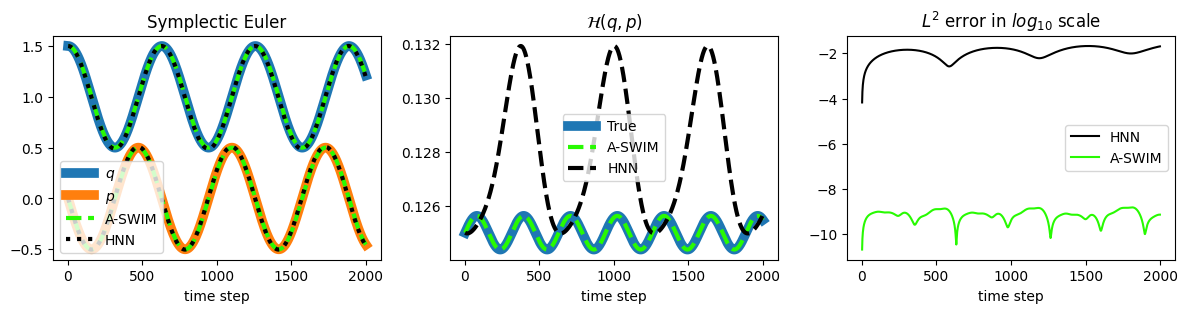

In [11]:
COLOR_ASWIM = '#28fa02' # green

dt = 1e-2
traj_length = 2000
x_0 = np.array([1.5, 0.])

symplectic_euler_traj = [x_0]
hnn_symp_euler_traj = [x_0]
sampled_hnn_symp_euler_traj = [x_0]
for _ in range(traj_length-1):
    x = symplectic_euler_traj[-1]
    x_next = symplectic_euler(x, dt)
    symplectic_euler_traj.append(x_next)

    x = hnn_symp_euler_traj[-1]
    x_next= hnn_symp_euler(x, dt)
    hnn_symp_euler_traj.append(x_next)

    x = sampled_hnn_symp_euler_traj[-1]
    x_next = sampled_hnn_symp_euler(x, dt)
    sampled_hnn_symp_euler_traj.append(x_next)

symplectic_euler_traj = np.array(symplectic_euler_traj)
hamiltonian_values = spring_hamiltonian(symplectic_euler_traj)

hnn_symp_euler_traj = np.array(hnn_symp_euler_traj)
hnn_hamil_values = spring_hamiltonian(hnn_symp_euler_traj)
hnn_l2_errors = np.linalg.norm(symplectic_euler_traj - hnn_symp_euler_traj, axis=-1)

sampled_hnn_symp_euler_traj = np.array(sampled_hnn_symp_euler_traj)
sampled_hnn_hamil_values = spring_hamiltonian(sampled_hnn_symp_euler_traj)
sampled_hnn_l2_errors = np.linalg.norm(symplectic_euler_traj - sampled_hnn_symp_euler_traj, axis=-1)

fig, ((ax0, ax1, ax2)) = plt.subplots(1, 3, figsize=(12, 2*GOLDEN_RATIO), dpi=100)
ax0.plot(range(1, traj_length+1), symplectic_euler_traj[:,0], label=r"$q$", linewidth=7)
ax0.plot(range(1, traj_length+1), symplectic_euler_traj[:,1], label=r"$p$", linewidth=7)
ax0.plot(range(1, traj_length+1), sampled_hnn_symp_euler_traj[:,0], label="A-SWIM", color=COLOR_ASWIM, linewidth=3, linestyle="dashed")
ax0.plot(range(1, traj_length+1), sampled_hnn_symp_euler_traj[:,1], color=COLOR_ASWIM, linewidth=3, linestyle="dashed")
ax0.plot(range(1, traj_length+1), hnn_symp_euler_traj[:,0], label="HNN", color="black", linestyle="dotted", linewidth=3)
ax0.plot(range(1, traj_length+1), hnn_symp_euler_traj[:,1], color="black", linestyle="dotted", linewidth=3)
ax0.set_title(r"Symplectic Euler")
ax0.set_xlabel(r"time step")
ax0.legend()

ax1.plot(range(1, traj_length+1), hamiltonian_values, linewidth=7, label="True")
ax1.plot(range(1, traj_length+1), sampled_hnn_hamil_values, linestyle='dashed', color=COLOR_ASWIM, linewidth=3, label="A-SWIM")
ax1.plot(range(1, traj_length+1), hnn_hamil_values, linewidth=3, color="black", linestyle="dashed", label="HNN")
ax1.set_xlabel(r"time step")
ax1.set_title(r"$\mathcal{H}(q,p)$")
ax1.legend()

ax2.set_title(r"$L^2$ error in $log_{10}$ scale")
ax2.plot(np.log10(hnn_l2_errors), label="HNN", color='k')
ax2.plot(np.log10(sampled_hnn_l2_errors), color=COLOR_ASWIM, label="A-SWIM")
ax2.set_xlabel(r"time step")
ax2.legend()
fig.tight_layout()


fig.savefig("../../static/images/posts/training-hnns-without-backprop/comparison-plot.png")